In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
'''
RSI can use various types of moving average-
exponential moving average, simple moving average, and more
here i'm using smoothed moving average 
'''

# smoothed moving average
def smma(series,n):
    
    output=[series[0]]
    
    for i in range(1,len(series)):
        temp=output[-1]*(n-1)+series[i]
        output.append(temp/n)
        
    return output


def rsi(data,n=14):
    
    delta=data.diff().dropna()
    
    up=np.where(delta>0,delta,0)
    down=np.where(delta<0,-delta,0)
    
    rs=np.divide(smma(up,n),smma(down,n))
    
    output=100-100/(1+rs)
    
    return output[n-1:]

In [3]:
# signal generation - when rsi goes >70, we short the stock, or vice versa
def signal_generation(df,method,n=14):
    
    df['rsi']=0.0
    df['rsi'][n:]=method(df['Close'],n=14)
    
    df['positions']=np.select([df['rsi']<30,df['rsi']>70], \
                              [1,-1],default=0)
    df['signals']=df['positions'].diff()
    
    return df[n:]

In [4]:
# visualizing our positions 
def plot(new,ticker):
    
    # close price with long/short positions
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(211)
    
    new['Close'].plot(label=ticker)
    ax.plot(new.loc[new['signals']==1].index,
            new['Close'][new['signals']==1],
            label='LONG',lw=0,marker='^',c='g')
    ax.plot(new.loc[new['signals']==-1].index,
            new['Close'][new['signals']==-1],
            label='SHORT',lw=0,marker='v',c='r')

    
    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')
    plt.xlabel('Date')
    plt.ylabel('price')
    
    plt.show()
    
    # rsi with overbought/oversold interval, capped at 30/70
    bx=plt.figure(figsize=(10,10)).add_subplot(212,sharex=ax)
    new['rsi'].plot(label='relative strength index',c='#522e75')
    bx.fill_between(new.index,30,70,alpha=0.5,color='#f22f08')
    
    bx.text(new.index[-45],75,'overbought',color='#594346',size=12.5)
    bx.text(new.index[-45],25,'oversold',color='#594346',size=12.5)
    
    plt.xlabel('Date')
    plt.ylabel('value')
    plt.title('RSI')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [6]:
'''
another, slightly more complicated way of using RSI
pattern recognition, similar to bollinger bands
this is the head0shoulder pattern directly on RSI instead of on price
'''

def pattern_recognition(df,method,lag=14):
    
    df['rsi']=0.0
    df['rsi'][lag:]=method(df['Close'],lag)    
    
    # period is defined as the horizon for finding the pattern
    period=25    
    
    # delta is the threshold of the difference between two prices
    # if the difference is smaller than delta, two prices aren't significantly different
    delta=0.2
    
    # the multipliers of delta
    head=1.1
    shoulder=1.1
    
    df['signals']=0
    df['cumsum']=0
    df['coordinates']=''
    
    # setting parameters after some tweaking
    entry_rsi=0.0
    counter=0
    exit_rsi=4
    exit_days=5
    
    # signal generation, again similar to bollinger bands
    # it's in the same github repo, so i won't type it all out again
    for i in range(period+lag,len(df)):
        
        # again, same premise as bollinger bands with moveon function
        moveon=False
        top=0.0
        bottom=0.0
        
        if (df['cumsum'][i]==0) and  \
        (df['Close'][i]!=max(df['Close'][i-period:i])):
            
            # get the head node j with maximum value in pattern finding period
            # note that dataframe is in datetime index
            j=df.index.get_loc(df['Close'][i-period:i].idxmax())
            
            # if the head node j is significantly larger than i, move to the next phase
            if (np.abs(df['Close'][j]-df['Close'][i])>head*delta):
                bottom=df['Close'][i]
                moveon=True
            
            # we try to find node k between node j and i, if k isn't significantly different, move on
            if moveon==True:
                moveon=False
                for k in range(j,i):    
                    if (np.abs(df['Close'][k]-bottom)<delta):
                        moveon=True
                        break
                        
            # so on and so forth for all of these functions
            if moveon==True:
                moveon=False
                for l in range(j,i-period+1,-1):
                    if (np.abs(df['Close'][l]-bottom)<delta):
                        moveon=True
                        break
                    
            if moveon==True:
                moveon=False        
                for m in range(i-period,l):
                    if (np.abs(df['Close'][m]-bottom)<delta):
                        moveon=True
                        break
            
            if moveon==True:
                moveon=False        
                n=df.index.get_loc(df['Close'][m:l].idxmax())
                if (df['Close'][n]-bottom>shoulder*delta) and \
                (df['Close'][j]-df['Close'][n]>shoulder*delta):
                    top=df['Close'][n]
                    moveon=True
                    
            if moveon==True:        
                for o in range(k,i):
                    if (np.abs(df['Close'][o]-top)<delta):
                        df.at[df.index[i],'signals']=-1
                        df.at[df.index[i],'coordinates']='%s,%s,%s,%s,%s,%s,%s'%(m,n,l,j,k,o,i)
                        df['cumsum']=df['signals'].cumsum()
                        entry_rsi=df['rsi'][i]
                        moveon=True
                        break
        
        # increase counter when we have a holding position
        # exit when either of the exit coditions are met
        if entry_rsi!=0 and moveon==False:
            counter+=1
            if (df['rsi'][i]-entry_rsi>exit_rsi) or \
            (counter>exit_days):
                df.at[df.index[i],'signals']=1
                df['cumsum']=df['signals'].cumsum()
                counter=0
                entry_rsi=0
            
    return df


In [7]:
# pattern visualization
def pattern_plot(new,ticker):
    
    # this part is to get a small slice of dataframe
    # so we can get a clear view of the head-shoulder pattern
    a,b=list(new[new['signals']!=0].iloc[2:4].index)
    
    # get for head-shoulder pattern visualization
    temp=list(map(int,new['coordinates'][a].split(',')))
    indexlist=list(map(lambda x:new.index[x],temp))
    
    # slicing
    c=new.index.get_loc(b)
    newbie=new[temp[0]-30:c+20]
    
    # our first plot is price with positions
    ax=plt.figure(figsize=(10,10)).add_subplot(211)
        
    newbie['Close'].plot(label=ticker)
    ax.plot(newbie['Close'][newbie['signals']==1],marker='^',markersize=12, \
            lw=0,c='g',label='LONG')
    ax.plot(newbie['Close'][newbie['signals']==-1],marker='v',markersize=12, \
            lw=0,c='r',label='SHORT')
    
    plt.legend(loc=0)
    plt.title('Positions')
    plt.xlabel('Date')
    plt.ylabel('price')
    plt.grid(True)
    plt.show()
    
    # our second plot is the head-shoulder pattern on RSI
    bx=plt.figure(figsize=(10,10)).add_subplot(212,sharex=ax)
    
    newbie['rsi'].plot(label='relative strength index',c='#f4ed71')
    
    # plot the overbought/oversold interval, positions and pattern
    bx.fill_between(newbie.index,30,70,alpha=0.6,label='overbought/oversold range',color='#000d29')
    bx.plot(newbie['rsi'][indexlist], \
            lw=3,alpha=0.7,marker='o', \
            markersize=6,c='#8d2f23',label='head-shoulder pattern')
    bx.plot(newbie['rsi'][newbie['signals']==1],marker='^',markersize=12, \
            lw=0,c='g',label='LONG')
    bx.plot(newbie['rsi'][newbie['signals']==-1],marker='v',markersize=12, \
            lw=0,c='r',label='SHORT')

    # captions for legibility
    for i in [(1,'Shoulder'),(3,'Head'),(5,'Shoulder')]:
        plt.text(indexlist[i[0]], newbie['rsi'][indexlist[i[0]]]+2, \
             '%s'%i[1],fontsize=10,color='#e4ebf2', \
             horizontalalignment='center', \
            verticalalignment='center')
        
    plt.title('RSI')
    plt.legend(loc=1)
    plt.xlabel('Date')
    plt.ylabel('value')
    plt.grid(True)
    plt.show()


In [12]:
def main():
    
    # randomly chucking apple in here because other stuff was bugging out
    ticker='AAPL'
    startdate='2016-01-01'
    enddate='2018-01-01'
    df=yf.download(ticker,start=startdate,end=enddate)
    new=signal_generation(df,rsi,n=14)

    plot(new,ticker)

[*********************100%%**********************]  1 of 1 completed
/var/folders/fk/n_3xyjtj6v31pk7c9z16xtn00000gn/T/ipykernel_18963/3564385631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi'][n:]=method(df['Close'],n=14)


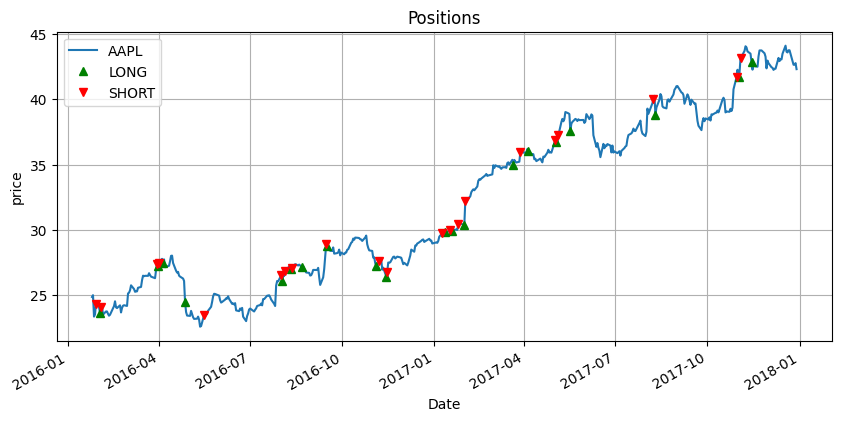

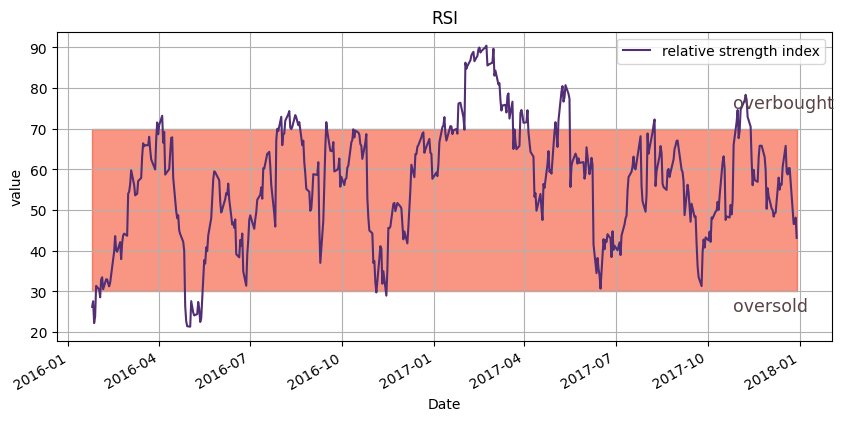

In [13]:
if __name__ == '__main__':
    main()